# Example-57: Approximate invariants spread

In [1]:
# In this example derivatives of approximate invariants spread with respect to parameters are computed
# Given a set of initial conditions, an objective function can be constructed

In [2]:
# Import

import torch

from matplotlib import pyplot as plt

from model.library.custom import Custom
from model.library.line import Line

from model.command.mapping import mapping
from model.command.trajectory import trajectory
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize
from model.command.wrapper import Wrapper

In [3]:
# Define 4D symplectic transformation

nux, nuy = torch.tensor([0.168, 0.201], dtype=torch.float64)
mux, muy = 2*torch.pi*nux, 2*torch.pi*nuy
cx, sx, cy, sy = mux.cos(), mux.sin(), muy.cos(), muy.sin()

def transformation(x, k, dp=None):
    qx, px, qy, py, *_ = x
    return torch.stack([
        cx*qx + sx*(px + qx**2 - qy**2 + k*(qx**3 - 3*qx*qy**2)),
        cx*(px + qx**2 - qy**2 + k*(qx**3 - 3*qx*qy**2)) - sx*qx,
        cy*qy + sy*(py - 2*qx*qy + k*(-3*qx**2*qy + qy**3)),
        cy*(py - 2*qx*qy + k*(-3*qx**2*qy + qy**3)) - sy*qy
    ])

k = torch.tensor(0.0, dtype=torch.float64)
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(x)
print(transformation(x, k))

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [4]:
# Define custom element using the above transformation

custom = Custom('custom', transformation, ['k'])
print(custom(x))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [5]:
# Define line with a single custom element

ring = Line('ring', [custom])
print(ring(x))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Test tracking 

k = torch.tensor(0, dtype=torch.float64)
x = torch.tensor([0.001, -0.0001, -0.005, 0.0001], dtype=torch.float64)

data = custom.data()
data['k'] = k
print(transformation(x, k) - custom(x, data=data))

data = ring.data()
data['custom']['k'] = k
print(transformation(x, k) - ring(x, data=data))

tensor([0., 0., 0., 0.], dtype=torch.float64)
tensor([0., 0., 0., 0.], dtype=torch.float64)


In [7]:
# Test wrapper

fn, *_ = mapping(ring, 0, 0, ('k', ['Custom'], None, None))

print(transformation(x, k) - fn(x, k.unsqueeze(-1)))

tensor([0., 0., 0., 0.], dtype=torch.float64)


In [8]:
# Test derivatives

k = torch.tensor([0.0], dtype=torch.float64)
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(torch.func.jacrev(transformation)(x, k.squeeze()))
print()

print(torch.func.jacrev(fn)(x, k))
print()

tensor([[ 0.4927,  0.8702,  0.0000,  0.0000],
        [-0.8702,  0.4927,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.3030,  0.9530],
        [ 0.0000,  0.0000, -0.9530,  0.3030]], dtype=torch.float64)

tensor([[ 0.4927,  0.8702,  0.0000,  0.0000],
        [-0.8702,  0.4927,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.3030,  0.9530],
        [ 0.0000,  0.0000, -0.9530,  0.3030]], dtype=torch.float64)



In [9]:
# Define and test trajectory generator

fn = trajectory(ring, [0], ('k', ['Custom'], None, None))

k = torch.tensor([0.0], dtype=torch.float64)
x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)

print(fn(1, x, k))
print()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=torch.float64)



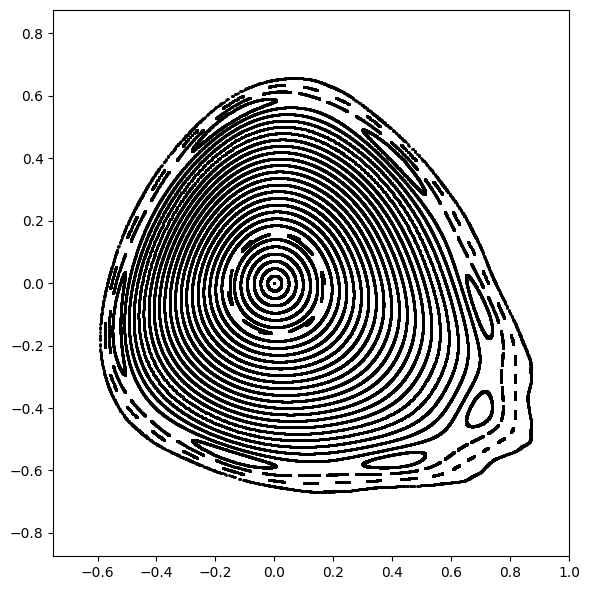

In [10]:
# Generate and plot phase space trajectories in horizontal plane

n = 2**12

k = torch.tensor([0.0], dtype=torch.float64)

qx = torch.linspace(0.00, 0.75, 32, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.zeros_like(qx)
py = torch.zeros_like(qx)

xs = torch.stack([qx, px, qy, py]).T

out = torch.vmap(fn, in_dims=(None, 0, None))(n, xs, k)
qxs, pxs, *_ = out.swapaxes(0, -1)

plt.figure(figsize=(6, 6))
for qx, px in zip(qxs.T, pxs.T):
    plt.errorbar(qx.cpu().numpy(), px.cpu().numpy(), fmt=' ', marker='o', ms=1, color='black')
plt.xlim(-0.750, 1.000)
plt.ylim(-0.875, 0.875)
plt.tight_layout()
plt.show()

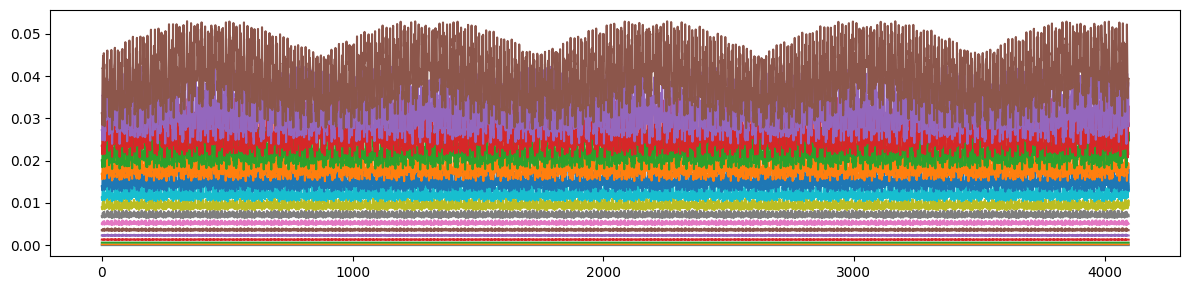

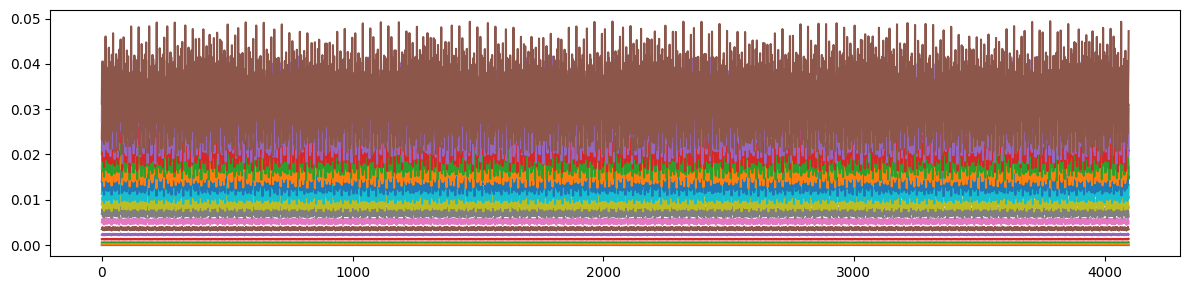

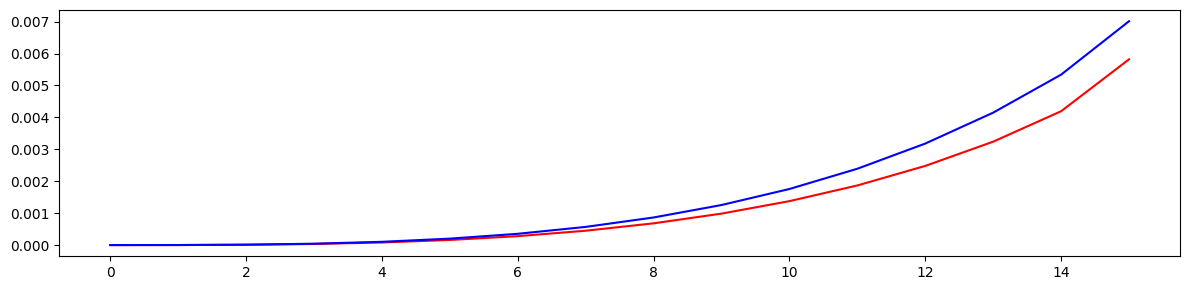

In [11]:
# Test linear invariants conservation

# Set approximate invariants

def ix(qx, px, qy, py):
    return 0.5*(qx**2 + px**2)

def iy(qx, px, qy, py):
    return 0.5*(qy**2 + py**2)

# Generate trajectories

n = 2**12

k = torch.tensor([0.0], dtype=torch.float64)

qx = torch.linspace(0.001, 0.250, 16, dtype=torch.float64)
px = torch.zeros_like(qx)
qy = torch.linspace(0.001, 0.250, 16, dtype=torch.float64)
py = torch.zeros_like(qx)

xs = torch.stack([qx, px, qy, py]).T

out = torch.vmap(fn, in_dims=(None, 0, None))(n, xs, k).swapaxes(1, -1)

# Compute invariants

ixs = torch.vmap(lambda trajectory: ix(*trajectory))(out)
iys = torch.vmap(lambda trajectory: iy(*trajectory))(out)

# Plot horizontal invariants vs number of iteration

plt.figure(figsize=(12, 3))
plt.plot(ixs.T.cpu().numpy())
plt.tight_layout()
plt.show()

# Plot vertical invariants vs number of iteration

plt.figure(figsize=(12, 3))
plt.plot(iys.T.cpu().numpy())
plt.tight_layout()
plt.show()

# Plot spead vs amplitude (measure of invariant conservation)

plt.figure(figsize=(12, 3))
plt.plot(ixs.std(-1).cpu().numpy(), color='red')
plt.plot(iys.std(-1).cpu().numpy(), color='blue')
plt.tight_layout()
plt.show()

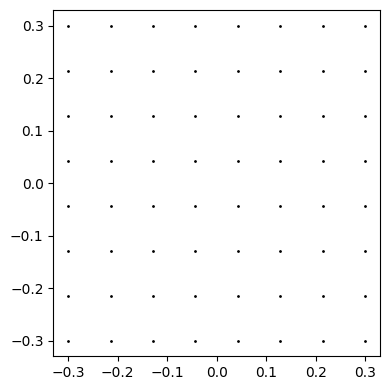

In [12]:
# Define spread merit function

# Set initial grid

n = 8

qx = torch.linspace(-0.3, 0.3, n, dtype=torch.float64)
qy = torch.linspace(-0.3, 0.3, n, dtype=torch.float64)

qx, qy = torch.stack(torch.meshgrid(qx, qy, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1).T

px = torch.zeros_like(qx)
py = torch.zeros_like(qy)

xs = torch.stack([qx, px, qy, py]).T

plt.figure(figsize=(4, 4))
plt.errorbar(qx.cpu().numpy(), qy.cpu().numpy(), fmt=' ', marker='o', ms=1, color='black')
plt.tight_layout()
plt.show()

# Define objective (mean spread over initials for each plane)

def objective(k, n=2**10):
    out = torch.vmap(fn, in_dims=(None, 0, None))(n, xs, k).swapaxes(1, -1)
    ixs = torch.vmap(lambda trajectory: ix(*trajectory))(out)
    iys = torch.vmap(lambda trajectory: iy(*trajectory))(out)
    return torch.stack([ixs.std(-1).mean(), iys.std(-1).mean()])

In [13]:
# Test objective

k = torch.tensor([0.0], dtype=torch.float64)

print(objective(k))
print()

tensor([0.0030, 0.0027], dtype=torch.float64)



In [14]:
# Compute derivative

print(torch.func.jacrev(objective)(k))

tensor([[-0.0007],
        [-0.0007]], dtype=torch.float64)
